In [ ]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
import sklearn.decomposition
import sklearn.feature_extraction
import sklearn.manifold

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import re

In [ ]:
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = data.data
labels = data.target

In [ ]:
def custom_tokenizer(text):
    # it's interesting that changing the tokenizer also changes the "shape" of the scatter graph

    # numbers
    text = re.sub(r'\b\d+\b', '', text)

    # words ending with 'ing'
    text = re.sub(r'\b\w+ing\b', '', text)

    # words ending with `
    text = re.sub(r'\b\w+`\b', '', text)

    #keeps words of length >2
    return re.findall(r'\b\w\w\w+\b', text)

tf_idf=sklearn.feature_extraction.text.TfidfVectorizer(max_features=1000, stop_words='english', lowercase=True,
                                                      tokenizer=custom_tokenizer, token_pattern=None)


In [ ]:
transformed=tf_idf.fit_transform(documents)

In [ ]:
pca=sklearn.decomposition.PCA(n_components=2)
pca_transformed=pca.fit_transform(transformed)

In [ ]:
tsne=sklearn.manifold.TSNE(n_components=2, init="random", random_state=42)
tsne_transformed=tsne.fit_transform(transformed)

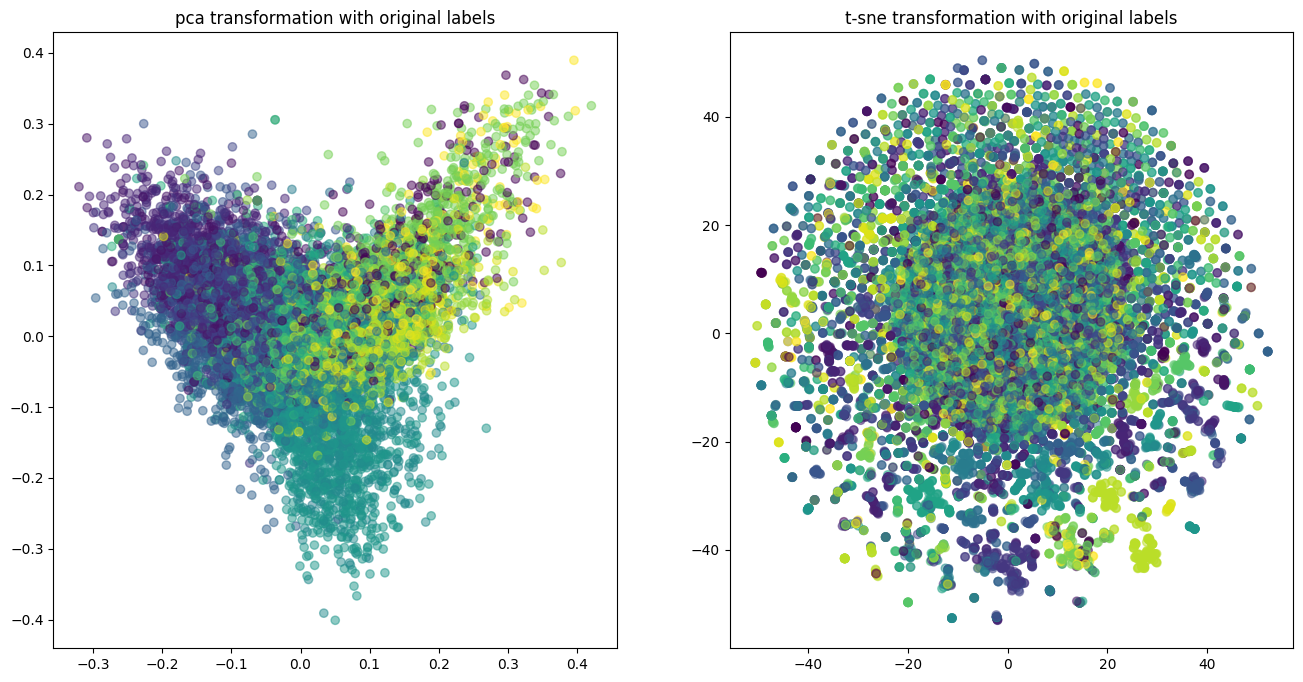

In [ ]:
_,axs=plt.subplots(1,2, figsize=(16,8))

axs[0].scatter(pca_transformed[:,0], pca_transformed[:,1], c=labels, alpha=0.5)
axs[1].scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=labels, alpha=0.5)
axs[0].title.set_text("pca transformation with original labels")
axs[1].title.set_text("t-sne transformation with original labels")

plt.show()


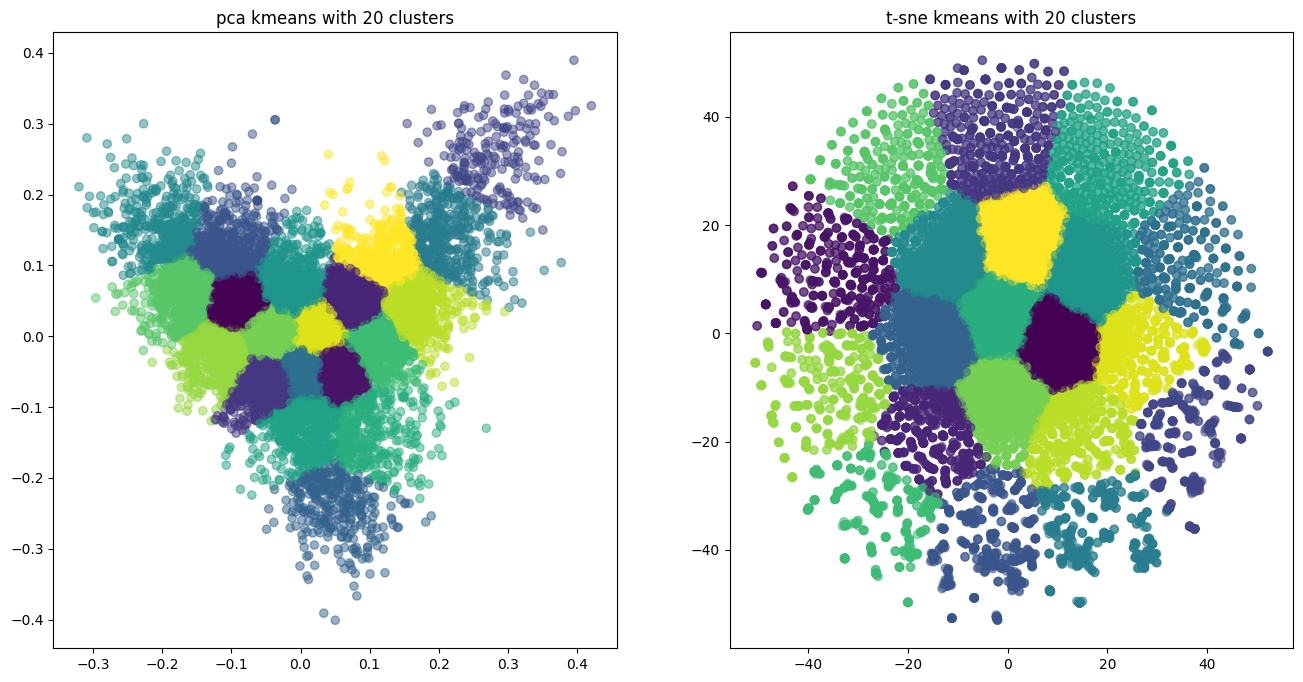

In [ ]:
# 20 because len(np.unique(labels))=20

k_means_pca=sklearn.cluster.KMeans(n_clusters=20, init='k-means++', random_state=42)
k_means_tsne=sklearn.cluster.KMeans(n_clusters=20, init='k-means++', random_state=42)

pca_clustering=k_means_pca.fit_predict(pca_transformed)
tsne_clustering=k_means_tsne.fit_predict(tsne_transformed)

_,axs=plt.subplots(1,2, figsize=(16,8))

axs[0].scatter(pca_transformed[:,0], pca_transformed[:,1], c=pca_clustering, alpha=0.5)
axs[1].scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=tsne_clustering, alpha=0.5)
axs[0].title.set_text("pca kmeans with 20 clusters")
axs[1].title.set_text("t-sne kmeans with 20 clusters")
plt.show()



Adjusted rand score for pca: 0.05347825282836261
Adjusted rand score for pca: 0.008381294761185737

heatmaps for pca and tsne kmeans


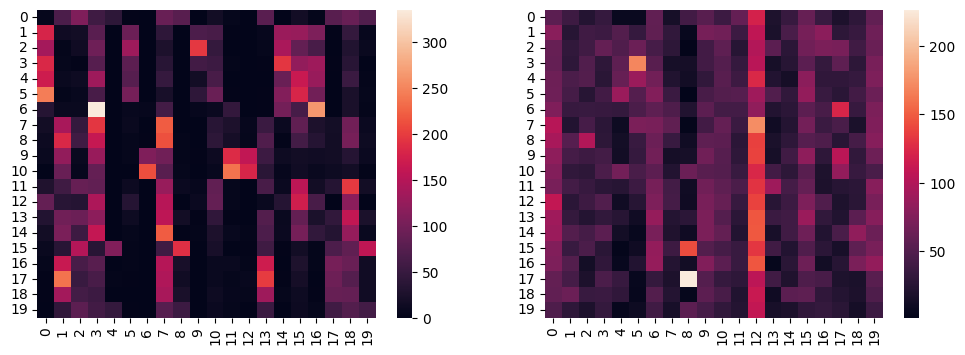

In [ ]:

fig, axs=plt.subplots(1,2, figsize=(12,4))

sns.heatmap(sklearn.metrics.confusion_matrix(labels,pca_clustering), ax=axs[0])
sns.heatmap(sklearn.metrics.confusion_matrix(labels,tsne_clustering), ax=axs[1])

plt.plot()

print("Adjusted rand score for pca:" ,sklearn.metrics.adjusted_rand_score(labels, pca_clustering))
print("Adjusted rand score for pca:" ,sklearn.metrics.adjusted_rand_score(labels, tsne_clustering))

print("\nheatmaps for pca and tsne kmeans")

In [ ]:
def b_cubed_precision(true_labels, pred_labels):
    precision = []
    for cluster in np.unique(pred_labels):
        cluster_indices = np.where(pred_labels == cluster)[0]
        cluster_true_labels = true_labels[cluster_indices]

        most_common_class = np.argmax(np.bincount(cluster_true_labels))
        num_same_class = np.sum(cluster_true_labels == most_common_class)

        precision.append(num_same_class / len(cluster_indices))

    return np.mean(precision)

def b_cubed_recall(true_labels, pred_labels):
    recall = []
    for true_class in np.unique(true_labels):
        class_indices = np.where(true_labels == true_class)[0]
        class_true_labels = true_labels[class_indices]

        cluster_counts = np.bincount(pred_labels[class_indices])
        max_cluster_count = np.max(cluster_counts)

        recall.append(max_cluster_count / len(class_indices))

    return np.mean(recall)

In [ ]:
precision_pca = b_cubed_precision(labels, pca_clustering)
recall_pca = b_cubed_recall(labels, pca_clustering)

precision_tsne = b_cubed_precision(labels, tsne_clustering)
recall_tsne = b_cubed_recall(labels, tsne_clustering)


print(f'KMEANS B-Cubed for PCA  :  precision_pca, recall_pca: {precision_pca} {recall_pca} ')
print(f'KMEANS B-Cubed for TSNE: precision_tsne, recall_tsne: {precision_tsne} {recall_tsne}')


KMEANS B-Cubed for PCA  :  precision_pca, recall_pca: 0.2774361917003499 0.20161868975027245 
KMEANS B-Cubed for TSNE: precision_tsne, recall_tsne: 0.11453138673687698 0.14458738206996352


In [ ]:
# using for loop I've found dbscan works the best for epsilon 1/100. It doesn't work for min_samples bigger than 1 because of the sparsity of data

dbscan_pca=sklearn.cluster.DBSCAN(eps=1/100, min_samples=1)
dbscan_tsne=sklearn.cluster.DBSCAN(eps=1/100, min_samples=1)

pca_dbscanned=dbscan_pca.fit_predict(pca_transformed)
tsne_dbscanned=dbscan_tsne.fit_predict(tsne_transformed)

precision_pca_dbscan = b_cubed_precision(labels, pca_dbscanned)
recall_pca_dbscan = b_cubed_recall(labels, pca_dbscanned)

precision_tsne_dbscan = b_cubed_precision(labels, tsne_dbscanned)
recall_tsne_dbscan = b_cubed_recall(labels, tsne_dbscanned)

print(f'DBSCAN B-Cubed for PCA  :  precision_pca, recall_pca: {precision_pca_dbscan} {recall_pca_dbscan} ')
print(f'DBSCAN B-Cubed for TSNE: precision_tsne, recall_tsne: {precision_tsne_dbscan} {recall_tsne_dbscan}')

DBSCAN B-Cubed for PCA  :  precision_pca, recall_pca: 0.8605803548860006 0.9706832912009744 
DBSCAN B-Cubed for TSNE: precision_tsne, recall_tsne: 0.9746515100802823 0.007645149286923415


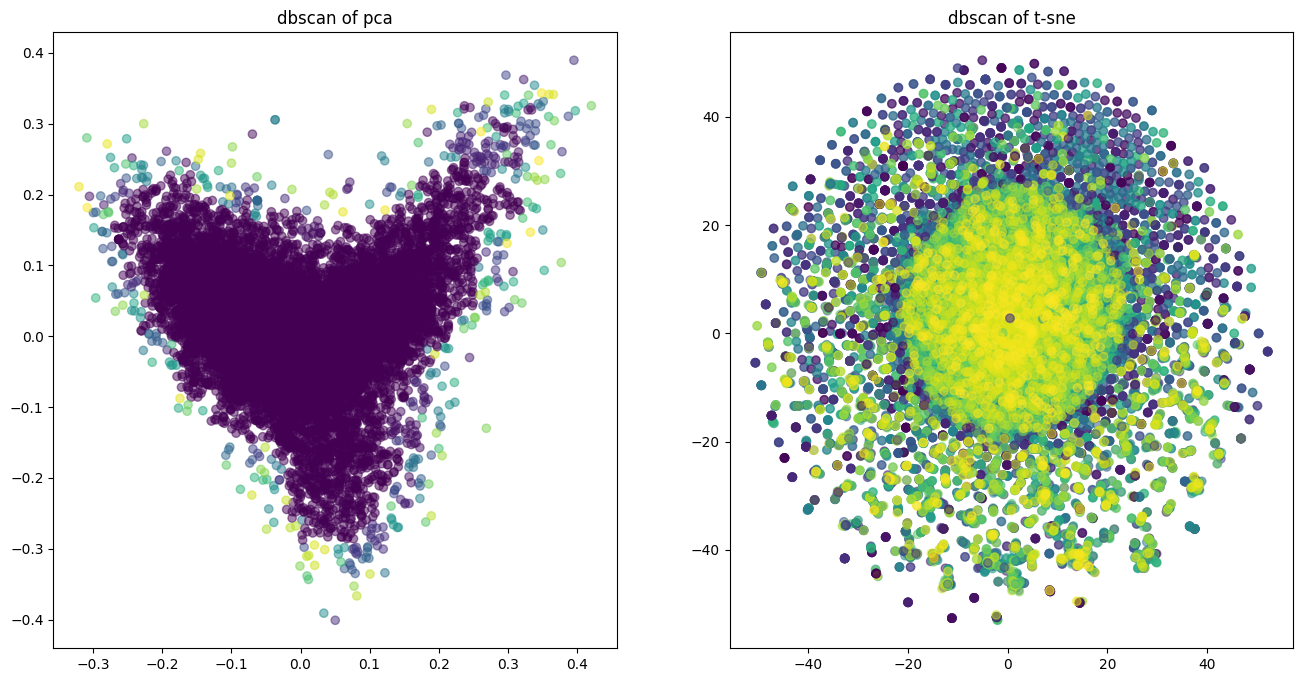

In [ ]:
_,axs=plt.subplots(1,2, figsize=(16,8))

axs[0].scatter(pca_transformed[:,0], pca_transformed[:,1], c=pca_dbscanned, alpha=0.5)
axs[1].scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=tsne_dbscanned, alpha=0.5)
axs[0].title.set_text("dbscan of pca")
axs[1].title.set_text("dbscan of t-sne")
plt.show()

# I have no idea why there's a point of different cluster in the center of dbscan tsne, it appeared after I tweaked the tokenizer a bit.

In [ ]:
print("PCA DBSCAN top 10 words for first 10 clusters")
feature_names=tf_idf.get_feature_names_out()
for cluster in np.unique(pca_dbscanned)[:10]:
    print(f"\ncluster {cluster}")

    doc_indices = np.where(pca_dbscanned == cluster)[0]

    cluster_matrix = transformed[doc_indices]

    mean_tfidf = cluster_matrix.mean(axis=0).A1

    top_indices = np.argsort(mean_tfidf)[::-1][:10]

    for i in top_indices:
        print(f"Word '{feature_names[i]:>15}' → Score {mean_tfidf[i]:.4f}")

PCA DBSCAN top 10 words for first 10 clusters

cluster 0
Word '           like' → Score 0.0254
Word '           just' → Score 0.0251
Word '            don' → Score 0.0241
Word '           know' → Score 0.0233
Word '          think' → Score 0.0206
Word '         people' → Score 0.0201
Word '           does' → Score 0.0191
Word '            use' → Score 0.0181
Word '           good' → Score 0.0173
Word '           time' → Score 0.0173

cluster 1
Word '           know' → Score 0.1835
Word '           does' → Score 0.1544
Word '            don' → Score 0.1383
Word '           read' → Score 0.0820
Word '         thanks' → Score 0.0767
Word '            new' → Score 0.0729
Word '        machine' → Score 0.0654
Word '           copy' → Score 0.0627
Word '         people' → Score 0.0621
Word '           want' → Score 0.0591

cluster 2
Word '         thanks' → Score 0.2276
Word '           mail' → Score 0.2110
Word '        advance' → Score 0.2068
Word '          drive' → Score 0.2044
Word '   

In [ ]:
print("PCA kmeans top 10 words for first 10 clusters")
for cluster in np.unique(pca_clustering):
    print(f"\nTop 10 words for cluster {cluster}")

    doc_indices = np.where(pca_clustering == cluster)[0]

    cluster_matrix = transformed[doc_indices]

    mean_tfidf = cluster_matrix.mean(axis=0).A1

    top_indices = np.argsort(mean_tfidf)[::-1][:10]

    for i in top_indices:
        print(f"Word '{feature_names[i]:>15}' → Score {mean_tfidf[i]:.4f}")

PCA kmeans top 10 words for first 10 clusters

Top 10 words for cluster 0
Word '         thanks' → Score 0.0482
Word '            use' → Score 0.0388
Word '           file' → Score 0.0322
Word '           does' → Score 0.0317
Word '           like' → Score 0.0284
Word '           know' → Score 0.0278
Word '        problem' → Score 0.0275
Word '           need' → Score 0.0271
Word '        program' → Score 0.0267
Word '           help' → Score 0.0265

Top 10 words for cluster 1
Word '          think' → Score 0.0354
Word '           just' → Score 0.0351
Word '           time' → Score 0.0296
Word '            did' → Score 0.0287
Word '           good' → Score 0.0256
Word '          right' → Score 0.0246
Word '           like' → Score 0.0244
Word '            don' → Score 0.0224
Word '            car' → Score 0.0220
Word '           said' → Score 0.0215

Top 10 words for cluster 2
Word '            don' → Score 0.0641
Word '           know' → Score 0.0569
Word '           just' → Score 0.0

## Names for PCA KMEANS clusters

Cluster 0: General Help/Support

Cluster 1: Opinions/Thoughts

Cluster 2: Knowledge/Beliefs

Cluster 3: Sales/Offers

Cluster 4: Religion/Faith

Cluster 5: Technology/Software Help

Cluster 6: Sports/Games

Cluster 7: Car/Automobile Discussions

Cluster 8: Religion/Christianity

Cluster 9: Technology/Windows

Cluster 10: Technology/Software Assistance

Cluster 11: Sports/Team Discussions

Cluster 12: Sports/Yearly Events

Cluster 13: Politics/Social Issues

Cluster 14: Technology/Software (Windows & DOS)

Cluster 15: General Problems/Needs

Cluster 16: Education/Software

Cluster 17: Politics/People's Opinions

Cluster 18: Personal Preferences

Cluster 19: Religion/Christian Beliefs



## Comparison of clusters for reference

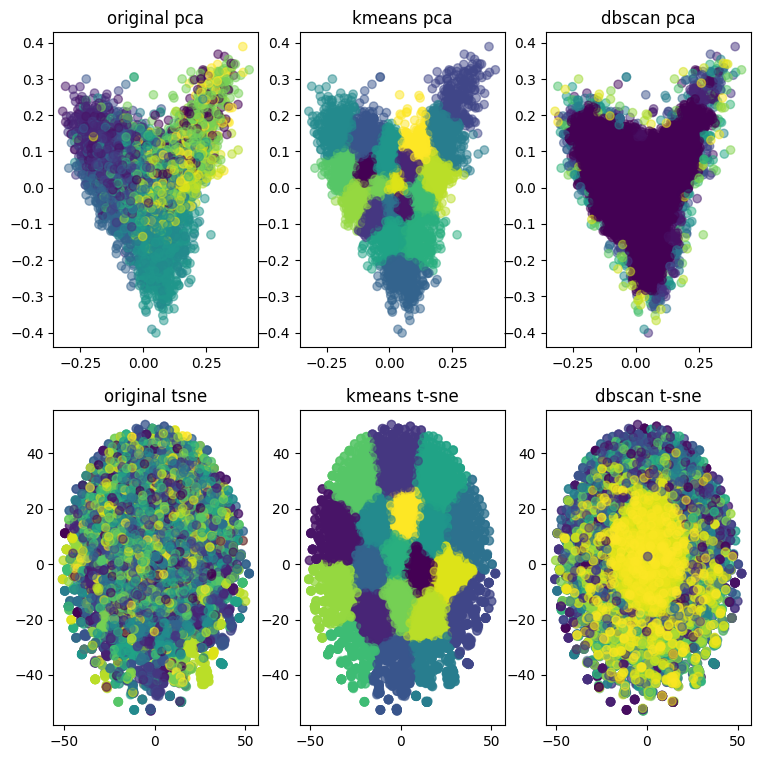

In [ ]:
_,axs=plt.subplots(2,3, figsize=(9,9))

axs[0,0].scatter(pca_transformed[:,0], pca_transformed[:,1], c=labels, alpha=0.5)
axs[1,0].scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=labels, alpha=0.5)
axs[0,1].scatter(pca_transformed[:,0], pca_transformed[:,1], c=pca_clustering, alpha=0.5)
axs[1,1].scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=tsne_clustering, alpha=0.5)
axs[0,2].scatter(pca_transformed[:,0], pca_transformed[:,1], c=pca_dbscanned, alpha=0.5)
axs[1,2].scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=tsne_dbscanned, alpha=0.5)

axs[0,0].title.set_text("original pca")
axs[1,0].title.set_text("original tsne")
axs[0,1].title.set_text("kmeans pca")
axs[1,1].title.set_text("kmeans t-sne")
axs[0,2].title.set_text("dbscan pca")
axs[1,2].title.set_text("dbscan t-sne")

plt.show()


## Reflective Questions

1. **Q: Which dimensionality reduction technique produced more meaningful visual separation? Why?**  
   **A:** PCA + DBSCAN produced the best precision and recall. On the contrary, t-SNE + DBSCAN has pure precision but misses most of the cluster's true points. KMeans has both worse precision and recall.

   - **DBSCAN B-Cubed for PCA:**  
     `precision_pca = 0.8605803548860006`  
     `recall_pca = 0.9706832912009744`
     
   - **DBSCAN B-Cubed for t-SNE:**  
     `precision_tsne = 0.9746515100802823`  
     `recall_tsne = 0.007645149286923415`
     
   - **KMeans B-Cubed for PCA:**  
     `precision_pca = 0.2774361917003499`  
     `recall_pca = 0.20161868975027245`
     
   - **KMeans B-Cubed for t-SNE:**  
     `precision_tsne = 0.11453138673687698`  
     `recall_tsne = 0.14458738206996352`

2. **Q: Which clustering algorithm matched the original topics better?**  
   **A:** Honestly, it's difficult to say. DBSCAN, though it performed better, gave lots of clusters. I've set the KMEANS to give the same number of clusters as the labels, which makes the analysis a bit easier. There are some matching topics, like topics of war, technology, sports, etc. So it's hard to compare them without using specific metrics.

3. **Q: What challenges did you face when clustering textual data?**  
   **A:** That it's extremely sparse. So I had to use coordinate matrices. Also, there are no clear clusters. If you look at the plots, they don't align at all — even if PCA + DBSCAN gave 0.86 precision.

4. **Q: Could you identify any meaningful topics based on the clusters alone?**  
   **A:** I don't think so. But the automated process (and better clustering) can group topics based on the top most used words. From what I've read, that's how recommendation systems work.  
   The problem with TF-IDF is that it skips semantics. Processing documents based on sentences might give better results, but in that case we'd need more documents, as individual sentences are even sparser than individual words.
